In [1]:
import numpy as np
import casatasks 
import casatools 
import casadata
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.visualization import AsinhStretch, ImageNormalize
%matplotlib widget
%load_ext autoreload
%autoreload 2

imagepath = "/raid/work/yamato/eDisk_data/L1489IRS/v0_images/L1489IRS_SBLB_continuum_robust_1.0_taper_3000klambda.pbcor.tt0.fits"

In [2]:
# import image
header = fits.getheader(imagepath)
data = fits.getdata(imagepath)

# coordinate
wcs = WCS(header)

# normalize and stretch
norm = ImageNormalize(data, vmin=0.0, stretch=AsinhStretch(a=0.03))

# center coordinate in the frame noticed in header["RADESYS"]
common_dir = "04h04m43.070001s +26d18m56.20011s"


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [3]:
# mask
peak = SkyCoord(common_dir, frame=header["RADESYS"].lower())
ra_ind, dec_ind = wcs.world_to_pixel(peak)

assert np.abs(header["CDELT1"]) == np.abs(header["CDELT2"])  # assert the pixel is square
dpix = np.abs(header["CDELT1"])  # in deg

assert header["NAXIS1"] == header["NAXIS2"]  # assert the image is square
npix = header["NAXIS1"]

# inner boundary of 6 arcsec
r_in_pix = 6.0 / (dpix * 3600)

# outer boundary of 8 arcsec
r_out_pix = 8.0 / (dpix * 3600)


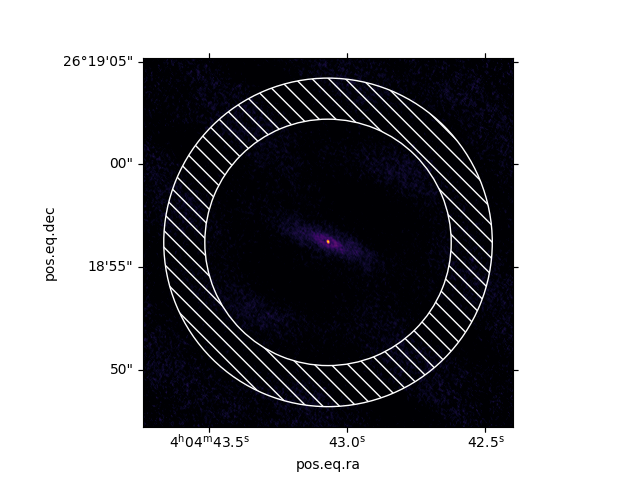

In [4]:
# noise annulus
annulus = patches.Annulus(
    xy=(ra_ind, dec_ind), r=r_out_pix, width=r_out_pix - r_in_pix, facecolor="none", edgecolor="white", hatch="\\\\"
)

# overplot noise annulus
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(data, origin="lower", cmap="inferno", norm=norm)
ax.add_artist(annulus)


In [5]:
# due to the bug in matplotlib.pathces, below do not worl well
# generate mask array
# x, y = np.meshgrid(np.arange(header['NAXIS1']), np.arange(header['NAXIS2']))
# pts = np.stack((x.flatten(), y.flatten()), axis=1)
# mask = annulus.contains_points(ax.transData.transform(pts)).reshape(header['NAXIS1'], header['NAXIS2'])

In [6]:
# instead use astropy
from astropy.modeling.models import Ellipse2D

x, y = np.meshgrid(np.arange(npix), np.arange(npix))
e = Ellipse2D(x_0=ra_ind, y_0=dec_ind, a=r_out_pix, b=r_out_pix) - Ellipse2D(
    x_0=ra_ind, y_0=dec_ind, a=r_in_pix, b=r_in_pix
)
mask = e(x, y)

# check plot
# plt.figure()
# plt.imshow(mask, origin='lower', cmap='Greys_r')

masked_data = data * mask
rms = np.sqrt((masked_data[masked_data != 0.0] ** 2).sum() / masked_data[mask != 0.0].size)
print("Measured rms:", rms, header["BUNIT"])


Measured rms: 2.128160702155128e-05 Jy/beam


In [7]:
# check by casa task imstat
# mask setup from imaging script
mask_ra = common_dir.split()[0].replace("h", ":").replace("m", ":").replace("s", "")
mask_dec = common_dir.split()[1].replace("d", ".").replace("m", ".").replace("s", "")

""" Define a noise annulus, measure the peak SNR in map """
noise_annulus = "annulus[[%s, %s],['6.0arcsec', '8.0arcsec']]" % (mask_ra, mask_dec)

rms_casa = casatasks.imstat(imagepath, region=noise_annulus)["rms"][0]
print("rms measured by imstat:", rms_casa, header["BUNIT"])
# well agree with rms measured by myself


rms measured by imstat: 2.1281616674250152e-05 Jy/beam


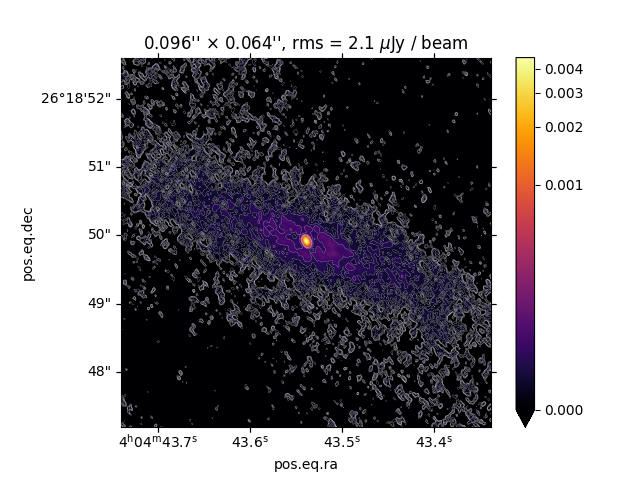

In [5]:
from analysis_utils import plot_2D_map
# beam and rms description string
rms = 2.128e-6
beam_rms_desc = r"{:.3f}'' $\times$ {:.3f}''".format(
    header["BMAJ"] * 3600, header["BMIN"] * 3600
) + r", rms = {:.1f} $\mu$Jy / beam".format(rms * 1e6)

# tuple of slices for image cutout
xmin = 2100
xmax = 3900
ymin = 2100
ymax = 3900
s = (slice(xmin, xmax), slice(ymin, ymax))

norm = ImageNormalize(data[s], vmin=0.0, stretch=AsinhStretch(a=0.03))
levels = np.array([3, 5, 7, 10, 15, 20, 30, 50, 100, 150, 200]) * rms

imshow_kw = {'norm': norm, 'cmap': 'inferno'}
contour_kw = {'levels': levels, "colors": "white", "linewidths": 0.2, "linestyles": "dashed"}

# contour map using measured rms
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)

plot_2D_map(data[s], ax=ax, title=beam_rms_desc, imshow_kw=imshow_kw, contour_kw=contour_kw)


### 2D Gaussian fit
- two components (compact and extended as in Sai et al. 2020)
- use casa task imfit

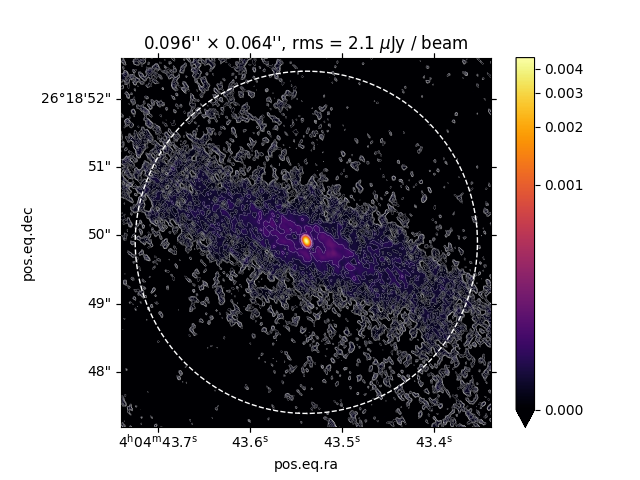

In [8]:
# check fit region
mask_pa = 0.0  # position angle of mask in degrees
mask_maj = 5.0  # semimajor axis of mask in arcsec
mask_min = 5.0  # semiminor axis of mask in arcsec
common_mask = "ellipse[[%s, %s], [%.1farcsec, %.1farcsec], %.1fdeg]" % (mask_ra, mask_dec, mask_maj, mask_min, mask_pa)

mask_maj_pix = mask_maj / (dpix * 3600)
mask_min_pix = mask_min / (dpix * 3600)

ra_ind_cut = ra_ind - xmin
dec_ind_cut = dec_ind - ymin

# mask ellipse
ellipse = patches.Ellipse(
    xy=(ra_ind_cut, dec_ind_cut),
    width=mask_maj_pix,
    height=mask_min_pix,
    angle=mask_pa + 90,
    facecolor="none",
    edgecolor="white",
    linestyle="dashed",
)

# overplot mask ellipse
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)
plot_2D_map(data[s], ax=ax, title=beam_rms_desc, imshow_kw=imshow_kw, contour_kw=contour_kw)
ax.add_artist(ellipse)
# include all >3sigma emission; looks ok


In [10]:
# set the initial estimates file
# peak intensity, peak xpixel, peak ypixel, maj, min, pa
# values from Sai et al. 2020
est_str_list = [
    "0.003, 3000, 3000, 0.097arcsec, 0.037arcsec, 49deg\n",
    "0.001, 3000, 3000, 4.1arcsec, 1.2arcsec, 69deg\n",
]  # need \n
estimates_filename = "./L1489IRS_cont_imfit.estimates"
with open(estimates_filename, "w") as f:
    f.writelines(est_str_list)

# set model and residual file
mod_filename = "./L1489IRS_cont_imfit.model.image"
res_filename = "./L1489IRS_cont_imfit.residual.image"


Start fitting 2D Gaussian to /raid/work/yamato/eDisk_data/L1489IRS/v0_images/L1489IRS_SBLB_continuum_robust_1.0_taper_3000klambda.pbcor.tt0.fits...
Done!
Fit converged!
{'component0': {'flux': <Quantity 0.00462234 Jy>,
                'flux_error': <Quantity 3.76067019e-05 Jy>,
                'inclination': <Quantity 47.10298804 deg>,
                'ispoint': True,
                'peak': <SkyCoord (ICRS): (ra, dec) in deg
    (61.17945693, 26.31561477)>,
                'peak_intensity': <Quantity 0.00450212 Jy / beam>,
                'peak_intensity_error': <Quantity 2.08370488e-05 Jy / beam>,
                'size': {'maj': <Quantity 0.09584938 arcsec>,
                         'min': <Quantity 0.06524301 arcsec>,
                         'pa': <Quantity 25.58457531 deg>}},
 'component1': {'flux': <Quantity 0.04366721 Jy>,
                'flux_error': <Quantity 0.0011899 Jy>,
                'inclination': <Quantity 75.92502286 deg>,
                'ispoint': False,
          

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


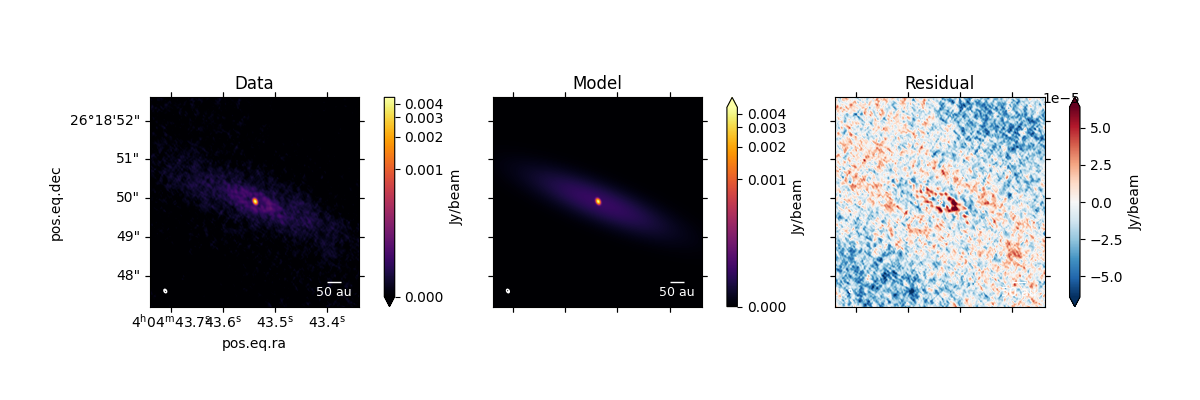

In [14]:
from analysis_utils import imfit_wrapper
result = imfit_wrapper(
    imagepath,
    region=common_mask,
    model=mod_filename,
    residual=res_filename,
    estimates=estimates_filename,
    rms=rms,
    plot=True,
    plot_region_slices=s,
    plot_kw={'imshow_kw': imshow_kw},
)
#


In [ ]:
def radial_profile(header, data, peak_sc, PA, incl):
    # generate relative axis
    offset_x = (peak_sc.ra.deg - header['CRVAL1']) * 3600 # offset along x from phsecenter in arcsec
    offset_y = (peak_sc.dec.deg - header['CRVAL2']) * 3600 # offset along y from phasecenter in arcsec

    dx = header['CDELT1'] * 3600 # x increment in arcsec
    dy = header['CDELT2'] * 3600 # y increment in arcsec

    npix = header['NAXIS1']
    assert header['NAXIS1'] == header['NAXIS2'] # assert image is square

    x = dx * (np.arange(npix) - (header['CRPIX1'] - 1)) - offset_x
    y = dy * (np.arange(npix) - (header['CRPIX2'] - 1)) - offset_y

    # deproject to the disk plane; assume geometrically thin disk
    xx, yy = np.meshgrid(x, y) 
    incl = np.radians(incl)
    PA = np.radians(PA)

    x_proj = (xx * np.sin(PA) + yy * np.cos(PA)) 
    y_proj = (- xx * np.cos(PA) + yy * np.sin(PA)) / np.cos(incl) # follow the formulation in Yen et al. 2016

    # polar coordinate
    r = np.sqrt(xx**2 + yy**2) # in arcsec
    theta = np.degrees(np.arctan2(y_proj, x_proj)) # in degree

    # check plot
    fig, ax = plt.subplots(1,1)
    plot_2D_map(header, data[s], X=x, Y=y, ax=ax, contour=False, pcolormesh_kw={'norm': norm, 'cmap':'inferno'})
    ax.contour(r, levels=10, colors='white')
    ax.contour(theta, levels=10, colors='white')


    # radial bin; width of 1/4 of beam major FWHM
    # rbin_width = header['BMAJ'] * 3600 * 0.25
    # rbin_out = 3.0
    # rbin = np.arange(rbin_width*0.5, rbin_out, rbin_width)

    # rad_prof = np.zeros(len(rbin))
    # rad_prof_scatter = np.zeros_like(rad_prof)

    # for i in range(len(rbin)):
    #     az_sample = data[(r >= rbin[i] - 0.5*rbin_width) & (r <= rbin[i] + 0.5*rbin_width)]

    #     rad_prof[i] = np.average(az_sample)
    #     rad_prof_scatter[i] = np.std(az_sample)
    
    # return rbin, rad_prof, rad_prof_scatter


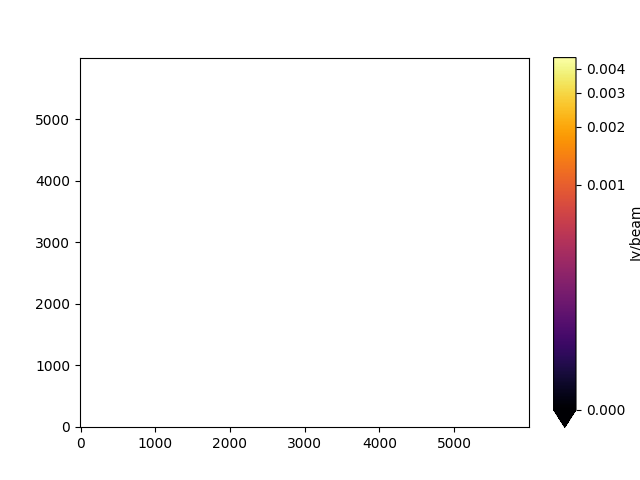

In [18]:
radial_profile(header, data, result['component1']['peak'], 68, 76)

In [12]:
data[()]

array([[ 1.1920866e-05,  1.6398697e-05,  2.0258874e-05, ...,
        -4.2192085e-05, -4.5374585e-05, -4.8682552e-05],
       [ 1.4470881e-05,  1.8924800e-05,  2.2577913e-05, ...,
        -4.5080429e-05, -4.8356560e-05, -5.1664236e-05],
       [ 1.6494660e-05,  2.0835954e-05,  2.4229037e-05, ...,
        -4.8060050e-05, -5.1354142e-05, -5.4584489e-05],
       ...,
       [-2.8938805e-06, -6.6297021e-06, -9.8148121e-06, ...,
        -1.8476587e-05, -1.8705121e-05, -1.9582294e-05],
       [-2.3715718e-06, -5.8986961e-06, -8.8737706e-06, ...,
        -1.8433519e-05, -1.9092909e-05, -2.0373955e-05],
       [-1.3682114e-06, -4.6479663e-06, -7.3903884e-06, ...,
        -1.8756517e-05, -1.9845553e-05, -2.1537329e-05]], dtype=float32)

In [19]:
{'imshow_kw': imshow_kw}.get('imshow_kw', {"cmap": "RdBu_r", "vmin": -3 * rms, "vmax": 3 * rms})

{'norm': <astropy.visualization.mpl_normalize.ImageNormalize at 0x7fab51f71580>,
 'cmap': 'inferno'}

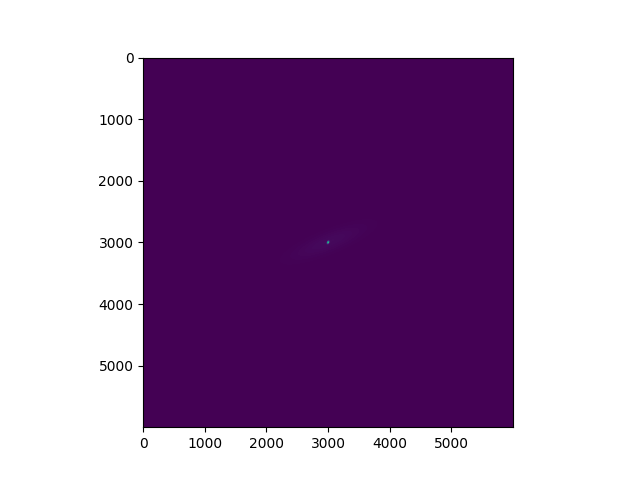

In [13]:
data = fits.getdata(res_filename+'.fits')
plt.figure()
plt.imshow(data)

In [37]:
import astropy.units as u
np.unwrap(np.rad2deg(np.arccos(10*u.deg/(20*u.deg))).value)

ValueError: diff requires input that is at least one dimensional